# Pulse Sequence Creation

In [81]:
import numpy as np
import pulser
from pprint import pprint
from pulser import Pulse, Sequence, Register

## 1. Creating the `Register`

The `Register` defines the positions of the atoms and their names of each one. There are multiple ways of defining a `Register`, the most customizable one being to create a dictionary that associates a name (the key) to a cooordinate (the value).

In [82]:
L = 4
square = np.array([[i, j] for i in range(L) for j in range(L)], dtype=float)
square -= np.mean(square, axis=0)
square *= 5

qubits = dict(enumerate(square))
reg = Register(qubits)

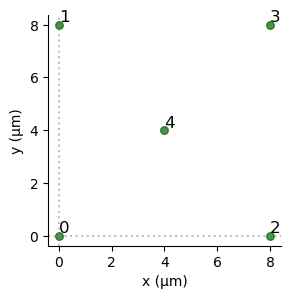

In [83]:
#another example
Lx = 2
Ly = 2
rect = [[i, j] for i in range(Lx) for j in range(Ly)]
rect.append([0.5, 0.5])
rect = np.array(rect, dtype=float)

#start at 0
#scale by 5 um
rect -= np.mean(square, axis=0)
rect *= 8

qubits = dict(enumerate(rect))
reg = Register(qubits)

reg.draw()

The `Register` class provides some useful features, like the ability to visualise the array and to rotate it.

The original array:


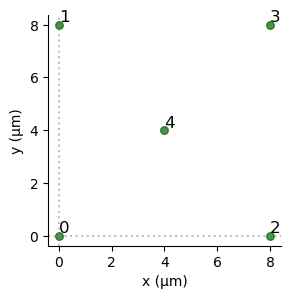

The rotated array:


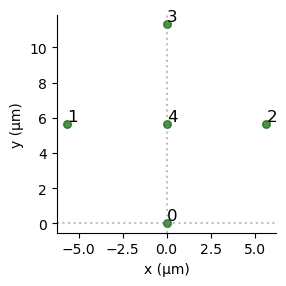

In [84]:
reg1 = Register(qubits)  # Copy of 'reg' to keep the original intact
print("The original array:")
reg1.draw()
reg1.rotate(45)  # Rotate by 45 degrees
print("The rotated array:")
reg1.draw()

If one doesn't particularly care about the name given to the qubits, one can also create a `Register` just from a list of coordinates (using the `Register.from_coordinates` class method). In this case, the qubit ID's are just numbered, starting from 0, in the order they are provided in, with the option of adding a common prefix before each number. Also, it automatically centers the entire array around the origin, an option that can be disabled if desired.

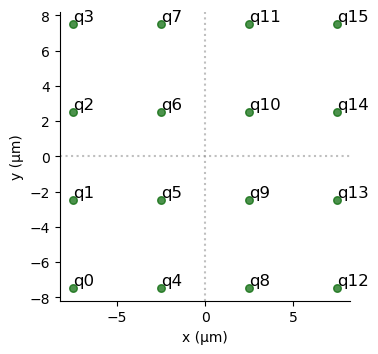

In [85]:
reg2 = Register.from_coordinates(
    square, prefix="q"
)  # All qubit IDs will start with 'q'
reg2.draw()

Furthermore, there are also built-in class methods from creation of common array patterns, namely:
- Square lattices in rectangular or square shapes
- Triangular lattices

We could, thus, create the same square array as before by doing:

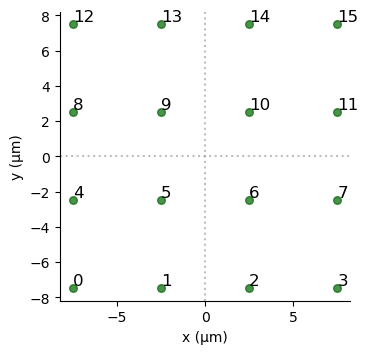

In [86]:
reg3 = Register.square(4, spacing=5)  # 4x4 array with atoms 5 um apart
reg3.draw()

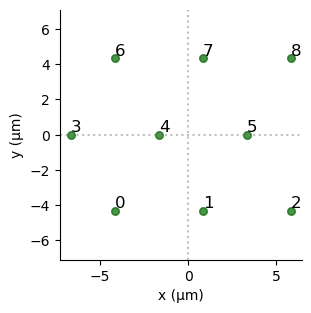

In [87]:
reg3 = Register.triangular_lattice(3,3,spacing=5)  # 4x4 array with atoms 5 um apart
reg3.draw()

## 2. Initializing the Sequence

To create a `Sequence`, one has to provide it with the `Register` instance and the device in which the sequence will be executed. The chosen device will dictate whether the register is valid or not.

We import the device (in this case, `Chadoq2`) from `pulser.devices` and initialize our sequence with the freshly created register:

In [88]:
from pulser.devices import Chadoq2

seq = Sequence(reg, Chadoq2)

## 3. Declaring the channels that will be used

Inspecting what channels are available on this device:

In [89]:
seq.available_channels

{'rydberg_global': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg'),
 'rydberg_local': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Minimum retarget time: 220 ns, Fixed retarget time: 0 ns, Max targets: 1, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg'),
 'raman_local': Raman.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Minimum retarget time: 220 ns, Fixed retarget time: 0 ns, Max targets: 1, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'digital')}

We're going to choose the `'rydberg_local'` and `'raman_local'` channels. Note how a declared channel is no longer reported as available.

The role of the channels is as follows. You address the qubit encodings through the channel, and on those, you apply the pulses. ground-rydberg is for the transition between |g> and |r> states as your qubit encoding. raman channel is for digital mode, where the two states are the ground state of the atom and the hyperfine level (only local pulses on that basis). FOr the ground-rydberg basis, there are both global and local channels. 

Question: Can one mix both of these within Pulser? Guess we will see.

In [90]:
seq.declare_channel("ch0", "raman_local")
print("Available channels after declaring 'ch0':")
pprint(seq.available_channels)

seq.declare_channel("ch1", "rydberg_local")
print("\nAvailable channels after declaring 'ch1':")
pprint(seq.available_channels)

Available channels after declaring 'ch0':
{'rydberg_global': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg'),
 'rydberg_local': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Minimum retarget time: 220 ns, Fixed retarget time: 0 ns, Max targets: 1, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg')}

Available channels after declaring 'ch1':
{'rydberg_global': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg')}


At any time, we can also consult which channels were declared, their specifications and the name they were given by calling:

In [91]:
seq.declared_channels

{'ch0': Raman.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Minimum retarget time: 220 ns, Fixed retarget time: 0 ns, Max targets: 1, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'digital'),
 'ch1': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Minimum retarget time: 220 ns, Fixed retarget time: 0 ns, Max targets: 1, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg')}

NOTE: for digital operations, one needs the ground-rydberg basis (for CZ gate, which needs the bloquade effect from Rydberg interaction) and the digital basis (Raman.Local) (for single qubit gates).

## 4. Composing the Sequence

Every channel needs to start with a target. For `Global` channels this is predefined to be all qubits in the device, but for `Local` channels this has to be defined. This initial target can be set through at channel declaration (see how `'ch1'` was set to target qubit `4`), or it can be done through the standard `target` instruction.

BUT - if you set an initial target in the channel declaration, and then change your mind, and update the target (for example, initial_target = 4, and then seq.target(2,"ch")) then some time (approx 200 ns) will be spent changing the target.

In [92]:
seq.target(1, "ch0")
seq.target(2, "ch1")

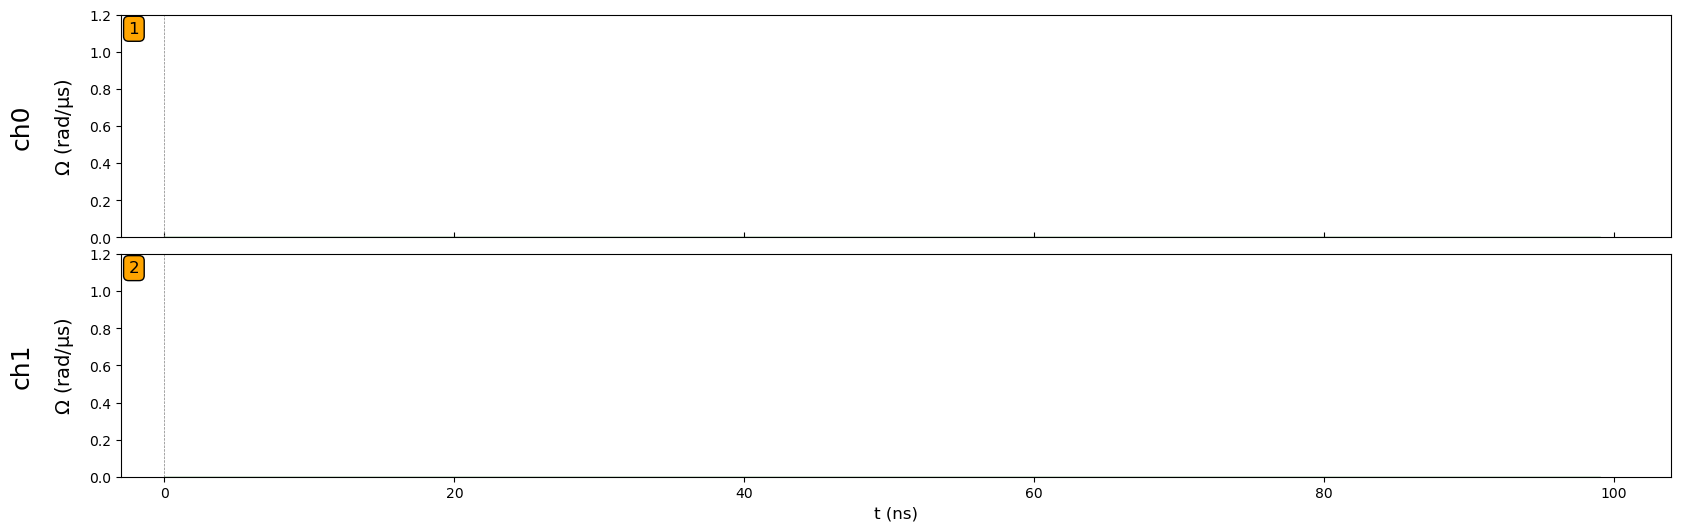

In [93]:
seq.draw()

Now both channels have an initial target, so we can start building the sequence. Let's start by creating a simple pulse with a constant Rabi frequency of 2 rad/µs and a constant detuning of -10 rad/µs that lasts 200 ns.

In [94]:
simple_pulse = Pulse.ConstantPulse(200, 2, -10, 0)
#takes in 'duration', 'amplitude', 'detuning', and 'phase'

Let's add this pulse to `'ch0'`:

In [95]:
seq.add(simple_pulse, "ch0")

Now, say we want to idle `'ch1'` for 100 ns while `'ch0'` is doing its pulse. We do that by calling: 

In [96]:
seq.delay(100, "ch1")

Next, we want to create a more complex pulse to add to `'ch1'`, where the amplitude and the detuning are not constant. To do that, we use `Waveform`s:

In [97]:
from pulser.waveforms import RampWaveform, BlackmanWaveform

duration = 1000
amp_wf = BlackmanWaveform(duration, np.pi / 2)  # Duration: 1000 ns, Area: pi/2
detuning_wf = RampWaveform(
    duration, -20, 20
)  # Duration: 1000ns, linear sweep from -20 to 20 rad/µs

We can visualize a waveform by calling:

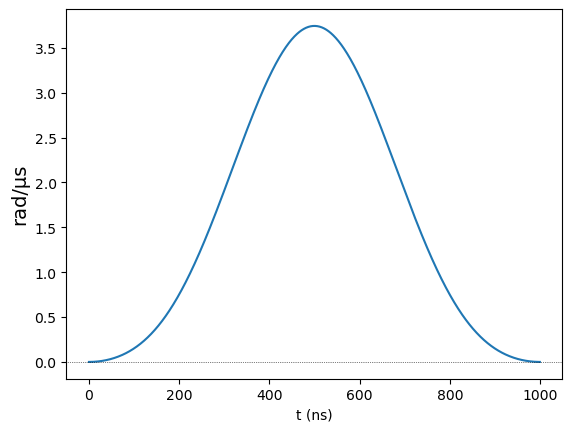

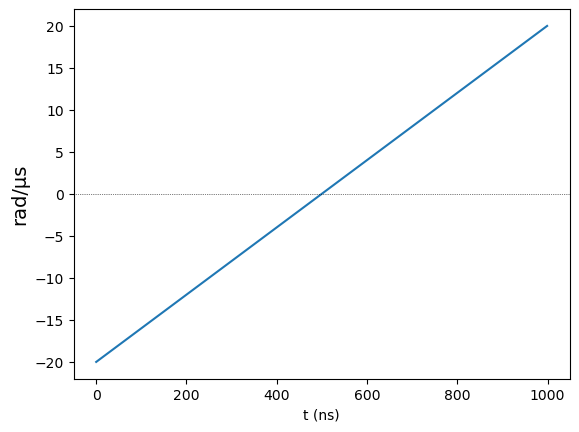

In [98]:
amp_wf.draw()
detuning_wf.draw()

Also, it is often convenient to find the integral of a waveform, which can be obtain by calling:

In [99]:
amp_wf.integral  # dimensionless

1.5707963267948968

We then create the pulse with the waveforms instead of fixed values and we can also visualize it:

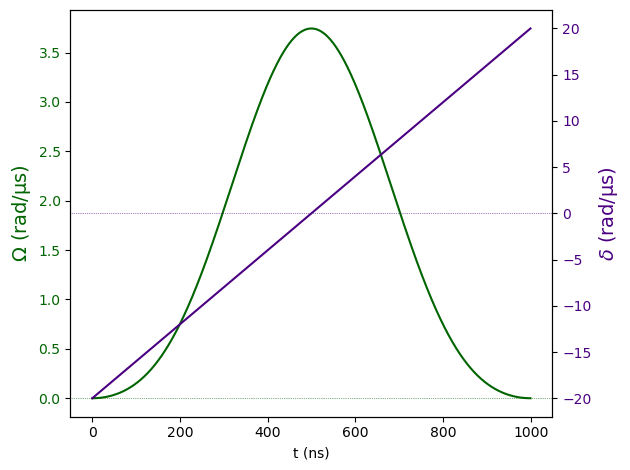

In [100]:
complex_pulse = Pulse(amp_wf, detuning_wf, phase=0)
complex_pulse.draw()

When we're satisfied, we can then add it to a channel:

In [101]:
seq.add(complex_pulse, "ch1")

Let's check the schedule to see how this is looking:

In [102]:
print(seq)

Channel: ch0
t: 0 | Initial targets: 1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 1

Channel: ch1
t: 0 | Initial targets: 2 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 2




We can also draw the sequence, for a more visual representation:

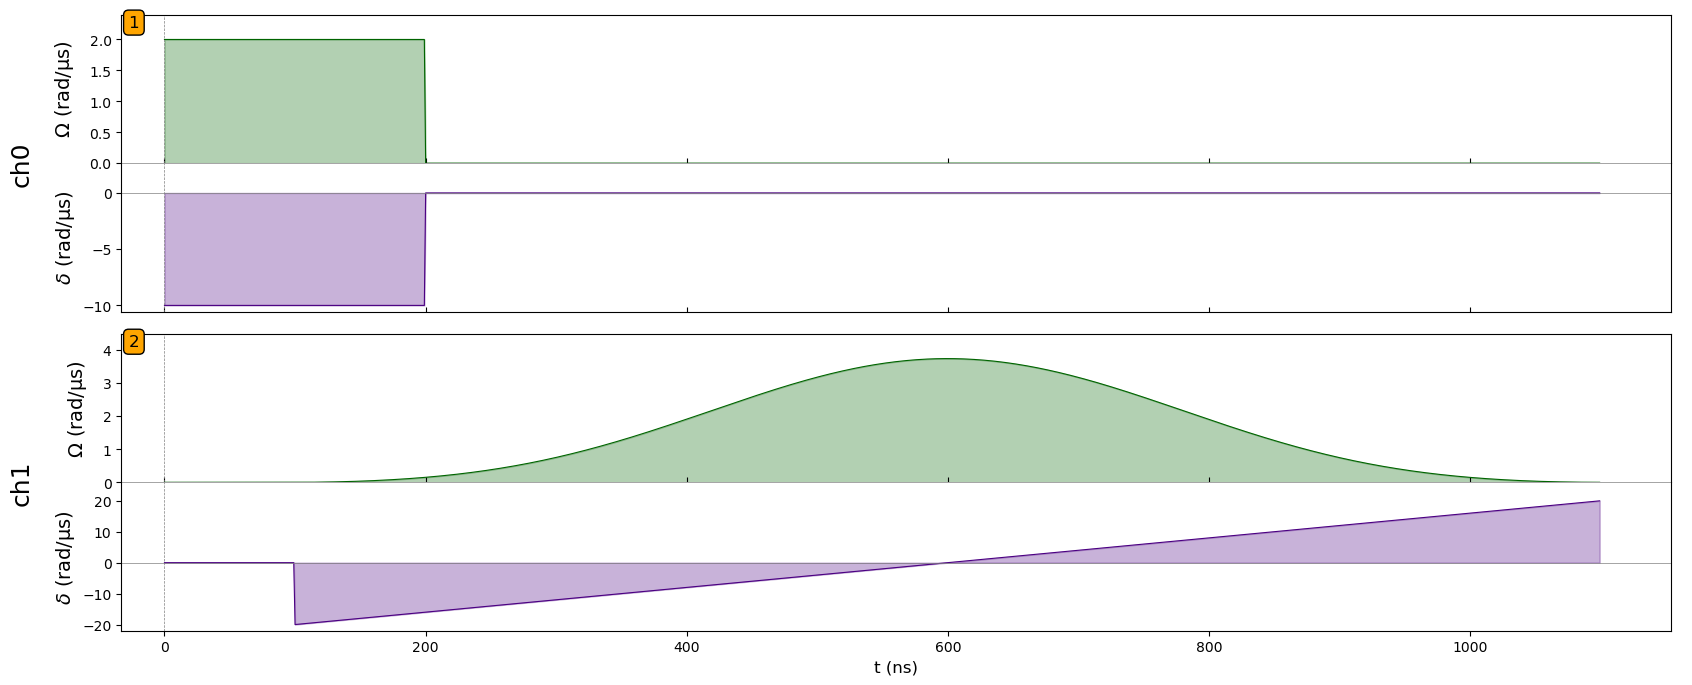

In [103]:
seq.draw()

Now, let's see how the Sequence builder handles conflicts (i.e. two channels acting on the same qubit at once). We're going to add a `complex_pulse`to `'ch0'`, but now we want to target it to qubit `4`, which is the same target of `'ch1'`.

Current Schedule:
Channel: ch0
t: 0 | Initial targets: 1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 1
t: 200->220 | Target: 2 | Phase Reference: 0.0
t: 220->1100 | Delay 
t: 1100->2100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 2

Channel: ch1
t: 0 | Initial targets: 2 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 2




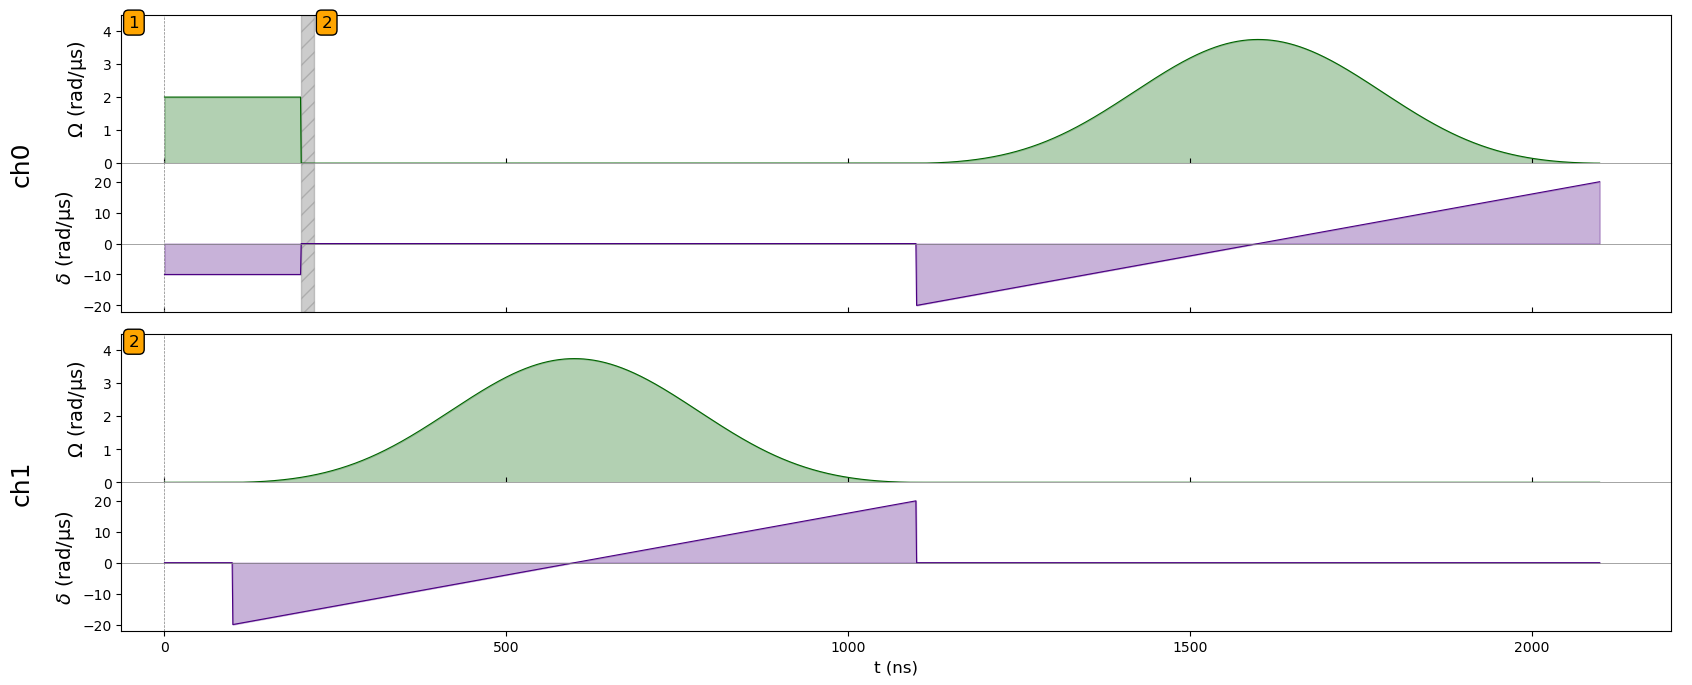

In [104]:
seq.target(2, "ch0")
seq.add(complex_pulse, "ch0")

print("Current Schedule:")
print(seq)
seq.draw()

By looking at the current schedule, we can see that `'ch0'` was delayed from `ti=220` to `tf=1100`, and only then was the `complex_pulse` added. The reason for this is simple: it had to wait for the pulse on `ch1`, also targeted to qubit `4`, to finish before it could apply its own. It behaved this way because, in `Sequence.add` there is a default argument `protocol='min-delay`.

Another protocol for pulse addition is `wait-for-all`, which makes the new pulse wait even if there is no conflict. Let's remove the conflict and add two `simple_pulse`s to `ch1` with the different protocols to see how the compare.

Current Schedule:
Channel: ch0
t: 0 | Initial targets: 1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 1
t: 200->220 | Target: 2 | Phase Reference: 0.0
t: 220->1100 | Delay 
t: 1100->2100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 2

Channel: ch1
t: 0 | Initial targets: 2 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 2
t: 1100->1100 | Target: 0 | Phase Reference: 0.0
t: 1100->1300 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 0
t: 1300->2100 | Delay 
t: 2100->2300 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 0




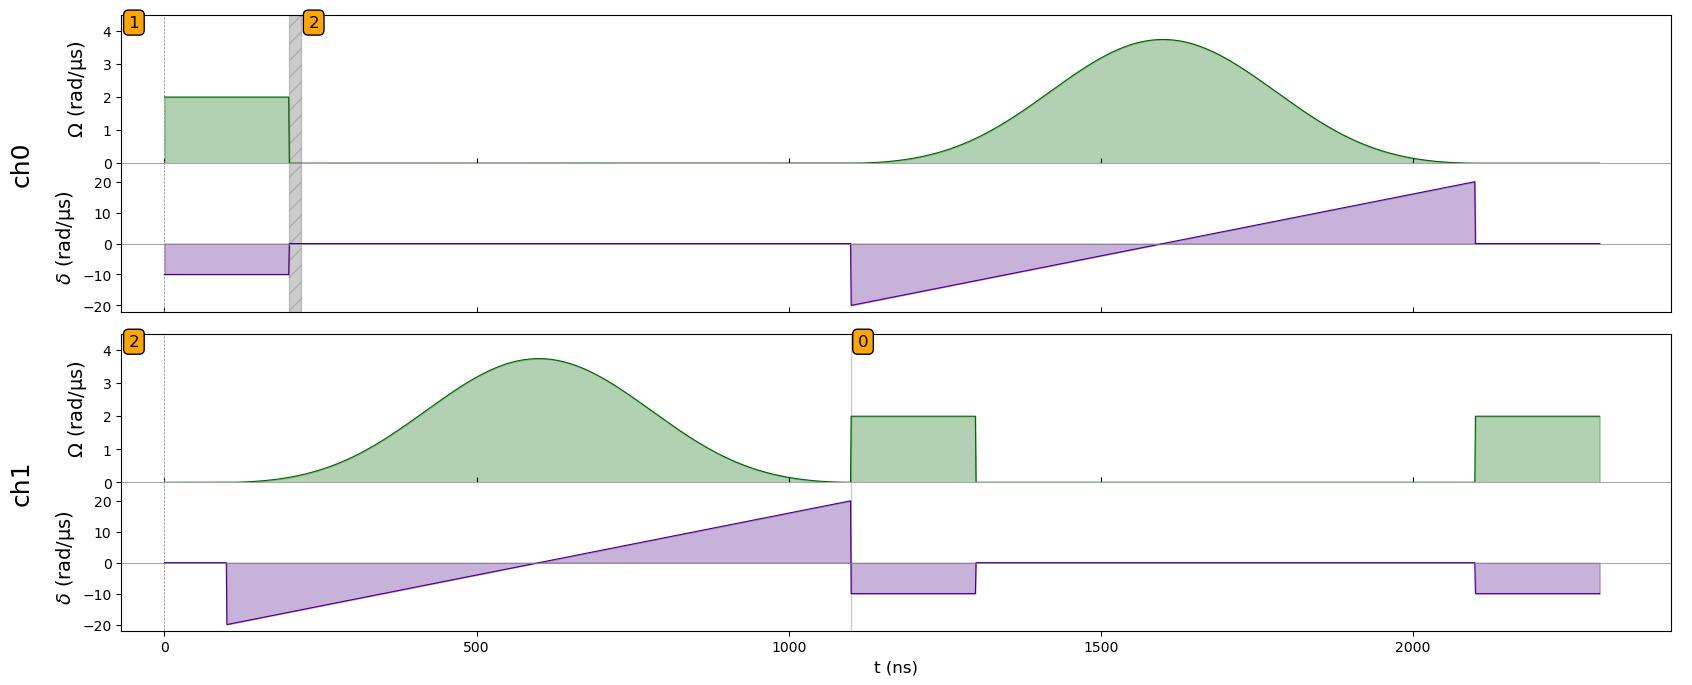

In [105]:
seq.target(0, "ch1")
seq.add(simple_pulse, "ch1", protocol="min-delay")
seq.add(simple_pulse, "ch1", protocol="wait-for-all")

print("Current Schedule:")
print(seq)
seq.draw()

Because we removed the conflict by changing the target of `ch1` to qubit `0`, we see that the first pulse was added without delay from `ti=1100` to `tf=1300` (i.e. while `complex_pulse` is still running in `ch0`). However, once we changed to `protocol='wait-for-all'`, there is now a delay (from `ti=1300` to `tf=2100`) that idles `ch1` until `ch0`is finished with its pulse, even though there was no conflict.

The third protocol is called `'no-delay'` which, as the name implies, never delays the channel where the pulse is being added, even if that means introducing a conflict.

Current Schedule:
Channel: ch0
t: 0 | Initial targets: 1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 1
t: 200->220 | Target: 2 | Phase Reference: 0.0
t: 220->1100 | Delay 
t: 1100->2100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 2
t: 2100->2100 | Target: 0 | Phase Reference: 0.0
t: 2100->3100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 0

Channel: ch1
t: 0 | Initial targets: 2 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 2
t: 1100->1100 | Target: 0 | Phase Reference: 0.0
t: 1100->1300 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 0
t: 1300->2100 | Delay 
t: 2100->2300 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 0




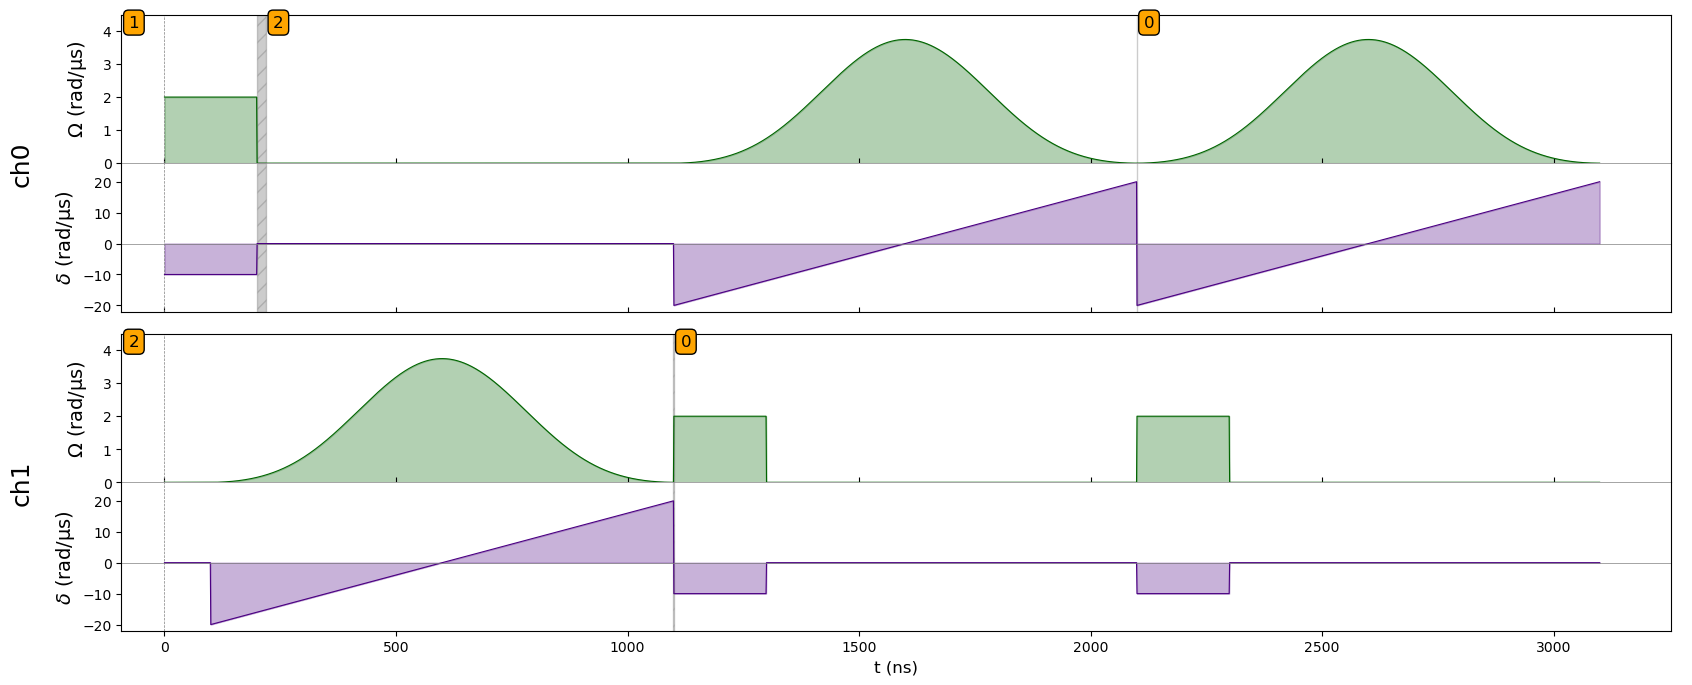

In [106]:
seq.target(0, "ch0")
seq.add(complex_pulse, "ch0", protocol="no-delay")

print("Current Schedule:")
print(seq)
seq.draw()

With this protocol, it is possible (though not advised), to create an overlap where multiple channels can be acting on the same qubit at the same time. Here, we can see that both act on qubit `0` from `ti=2100` to `tf=2300`.

## 5. Measurement

To finish a sequence, we measure it. A measurement signals the end of a sequence, so after it no more changes are possible. We can measure a sequence by calling:

In [107]:
seq.measure(basis="ground-rydberg")

When measuring, one has to select the desired measurement basis. The availabe options depend on the device and can be consulted by calling:

In [108]:
Chadoq2.supported_bases

{'digital', 'ground-rydberg'}

And so, we've obtained the final sequence!

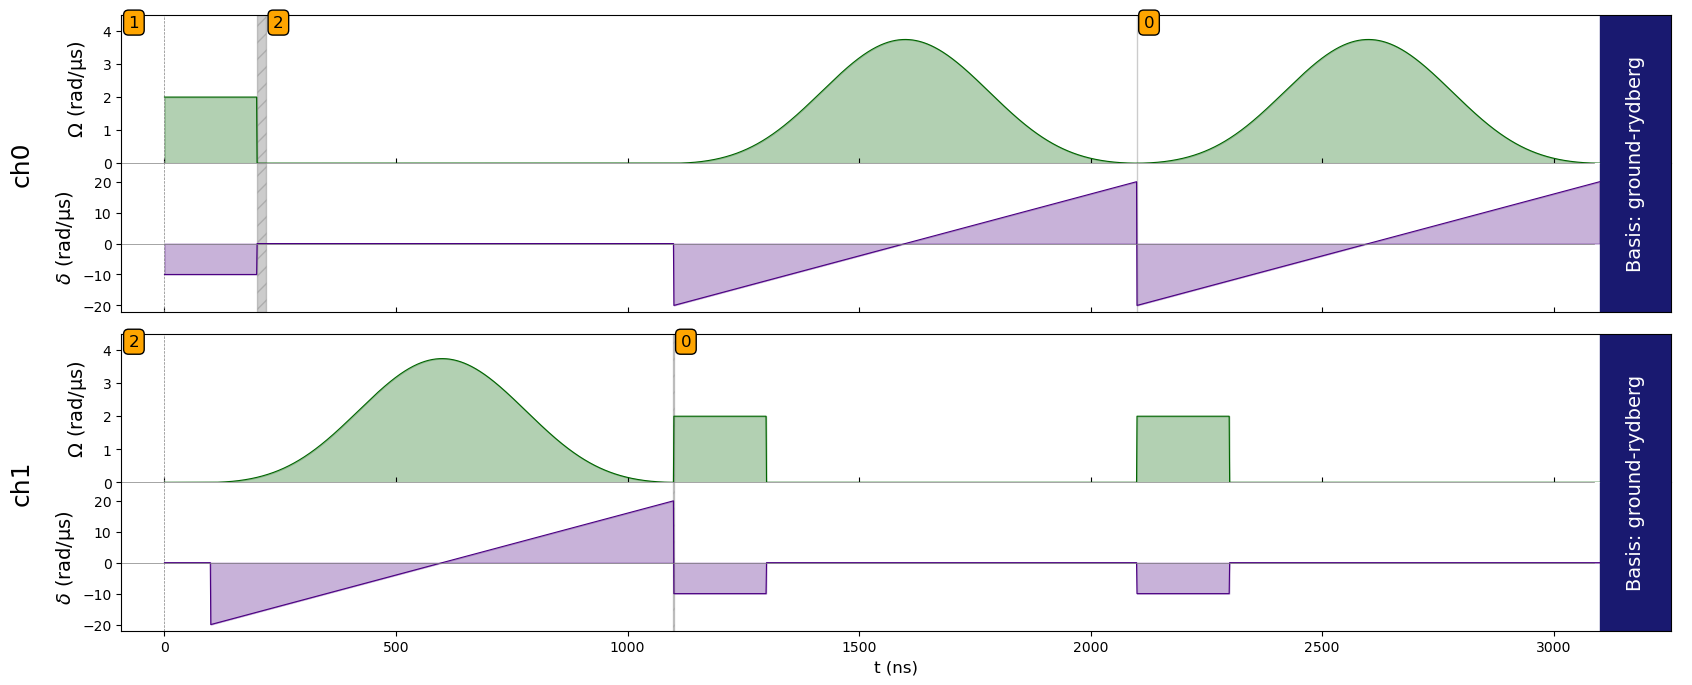

In [109]:
seq.draw()

# Practice

pulse = Pulse.ConstantDetuning(BlackmanWaveform(t_pulse, np.pi / 2.0), 0, np.pi / 2)